# Improving accuracy of models

In the previous example, we constructed scalar models

Once the modes have been found, we can then make use of them to construct scalar models of our meta-atoms.

In [1]:
# setup 2D plotting 
%matplotlib inline
from openmodes.ipython import matplotlib_defaults
matplotlib_defaults()
import matplotlib.pyplot as plt

# the numpy library contains useful mathematical functions
import numpy as np

# import useful python libraries
import os.path as osp

# import the openmodes package
import openmodes
from openmodes.sources import PlaneWaveSource
from openmodes.integration import RectangularContour, DunavantRule

## Setup simulation

For improved accuracy, we increase the order of all surface integrals from 5 (the default) to 10. Naturally this increases the time taken for all calculations. This increased accuracy is particularly important for modes with large damping rate $\Omega$.

In [2]:
sim = openmodes.Simulation(integration_rule=DunavantRule(10), notebook=True)
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, "SRR.geo"), parameters={'inner_radius': 2.5e-3}, mesh_tol=0.8e-3)
ring = sim.place_part(mesh)

## Find modes by contour integration

Next, we use a more advanced *contour integration* method to find the location of modes. This is required to find modes which are highly damped, and hence are further away from the $j\omega$ axis.

This method requires more computation than the simpler approach, but it yields more reliable results. It is also necessary to specify a region of complex frequency $s$ in which the modes are expected to be found.

In [3]:
contour = RectangularContour(-1e11+1e9j, 5e11j)

estimates = sim.estimate_poles(contour)
refined = sim.refine_poles(estimates)
modes = refined.add_conjugates()

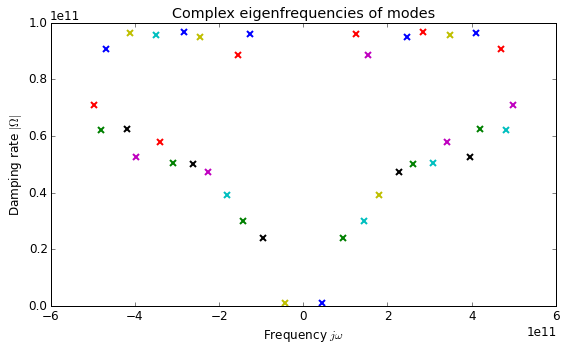

In [4]:
plt.figure()
plt.plot(modes.s.imag, np.abs(modes.s.real), 'x')
plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $|\Omega|$')
plt.title('Complex eigenfrequencies of modes')
plt.tight_layout()
plt.show()

Note the very large number of modes which were found, including some with extremely high damping.

## Exact extinction calculation

Again, we calculate the exact result for comparison purposes

In [5]:
num_freqs = 101
freqs = np.linspace(1e9, 30e9, num_freqs)

e_inc = np.array([1.0, 1.0, 0])
k_dir = np.array([0, 0, 1])
plane_wave = PlaneWaveSource(e_inc, k_dir, p_inc =1.0)

area = np.pi*(0.5*mesh.max_distance)**2

extinction = np.empty(num_freqs, np.complex128)
extinction_modes = np.empty((num_freqs, len(modes)), np.complex128)

In [6]:
for freq_count, s in sim.iter_freqs(freqs):
    Z = sim.impedance(s)
    V = sim.source_vector(plane_wave, s)
    extinction[freq_count] = np.vdot(V, Z.solve(V))

## Extinction from model of modes

Now we calculate the extinction based on the scalar model for each mode, and also time this calculation

In [7]:
for freq_count, s in sim.iter_freqs(freqs):
    V = sim.source_vector(plane_wave, s)    
    I_modes = (1/(s - modes.s) + 1/modes.s)*modes.vl.dot(V)
    extinction_modes[freq_count] = V.vdot(modes.vr*I_modes)

We can now see that the extinction cross-section of each mode can be calculated separately

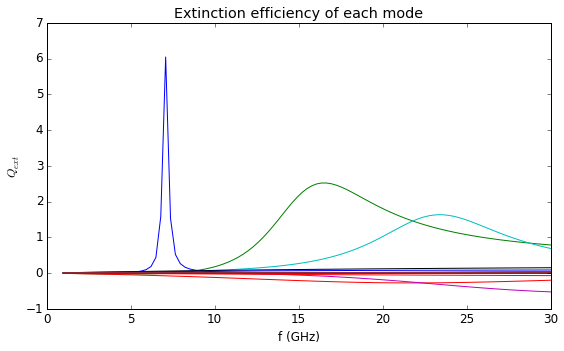

In [8]:
plt.figure()
plt.plot(freqs*1e-9, extinction_modes.real/area);
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$Q_{ext}$')
plt.title('Extinction efficiency of each mode')
plt.tight_layout()
plt.show()

We can see that the 3 dominant modes are still contributing as before, and most of the modes we found have a negligible effect. However, a few highly-damped modes are showing a *negative contribution to extinction*.

This may sounds like unphysical nonsense, but it is actually a genuine feature of open resonators. The modes are non-orthogonal, so they interfere with each other, and these interference terms can be negative. Of course, the total extinction from all modes must always be positive.

## Comparison with exact results

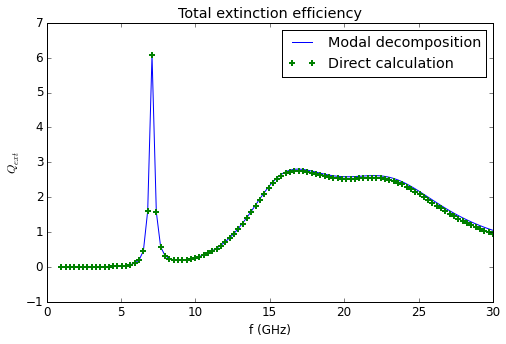

In [9]:
plt.figure()
plt.plot(freqs*1e-9, extinction.real/area)
plt.plot(freqs*1e-9, np.sum(extinction_modes.real, axis=1)/area, '+')
plt.legend(['Modal decomposition', 'Direct calculation'])
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$Q_{ext}$')
plt.title('Total extinction efficiency')
plt.show()

By including the additional modes, and using the higher order integration rule, we see that the modal model can give almost exact results for extinction.

The reactive part is also shown below. The remaining disagreement may be due to the relatively coarse mesh which has been used.

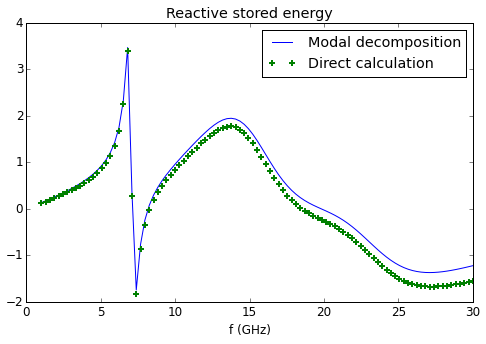

In [10]:
plt.figure()
plt.plot(freqs*1e-9, extinction.imag/area)
plt.plot(freqs*1e-9, np.sum(extinction_modes.imag, axis=1)/area, '+')
plt.legend(['Modal decomposition', 'Direct calculation'])
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.title('Reactive stored energy')
plt.show()